In [1]:
] activate .

  Activating environment at `C:\Users\harih\Documents\gitrepos\schelling\Project.toml`


In [56]:
using Parameters, Plots, LinearAlgebra, PyPlot, Statistics, IJulia

In [3]:
backend(:plotly)

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots C:\Users\harih\.julia\packages\Plots\Bfn5f\src\backends.jl:372


Plots.PlotlyBackend()

In [4]:
Game5 = @with_kw (
    nrow = 20,
    ncol = 20,
    kindlist = [1 2],
    board = rand(0:maximum(kindlist), (nrow, ncol)),
    kindshare_thresh = 0.3
)


Game = Game5

##NamedTuple_kw#257 (generic function with 2 methods)

In [5]:
agent = @with_kw (
    x = rand(1:nrow), y = rand(1:ncol),
    kind
)

##NamedTuple_kw#258 (generic function with 2 methods)

In [40]:
"""
Gets the share of neighbours for a given agent
who are of the same kind
"""
function a_neighbour_kindshare(a, game)
        
    neighbours = Vector{Int64}[]
    
    if a.kind == 0
        push!(neighbours, [-999])
    else
        for xadj in (-1, 0, 1)
            for yadj in (-1, 0, 1)
                if (a.x + xadj) ≤ game.nrow && (a.x + xadj) > 0 && (a.y + yadj) ≤ game.ncol && (a.y + yadj) > 0
                    newx = a.x + xadj
                    newy = a.y + yadj
                    board_pos_kind = game.board[newx, newy]
                    if board_pos_kind != 0 && !all((newx, newy) == (a.x, a.y))
                        samekind = a.kind == board_pos_kind
                        push!(neighbours, [samekind])
                    end
                end
            end
        end
    end
    
    if length(neighbours) == 0
        neighbours = [0]
    end
    kindshare = mean(neighbours)
    return kindshare[1]
end

a_neighbour_kindshare

In [7]:
"""
Get a matrix the same size as the board
with each block representing its
kind-share i.e. share of neighbours with
same type
"""
function get_game_kindshare(game)
    
    kindshare_mat = zeros(Float64, (game.nrow, game.ncol))
    
    for i in 1:game.nrow
        for j in 1:game.ncol
            a = agent(
                x = i,
                y = j,
                kind = game.board[i, j]
            )
            akindshare = a_neighbour_kindshare(a, game)
            kindshare_mat[i, j] = akindshare
        end
    end
    
    return kindshare_mat
    
end

get_game_kindshare

In [8]:
function ishappy(a, game)
    
    kind_share = a_neighbour_kindshare(a, game)
    happy = kind_share ≥ game.kindshare_thresh
    
    return happy
    
end

ishappy (generic function with 1 method)

In [9]:
function board_happy(game)
    
    board_ishappy = zero(game.board)
   
    for i in 1:game.nrow
        for j in 1:game.ncol
            
            if game.board[i, j] != 0
                a = agent(
                    x = i, y = j, kind = game.board[i, j]
                )
                board_ishappy[i, j] = ishappy(a, game)
            else
                board_ishappy[i, j] = -999
            end
        end
    end
    
    return board_ishappy
    
end

board_happy (generic function with 1 method)

In [10]:
function new_move(a, game, method = "random")
    
    empty_spots = findall(a->a==0, game.board)
    
    if lowercase(method) == "random"
        
        if length(empty_spots) > 0
            random_idx = rand(1:length(empty_spots))
            move_loc = empty_spots[random_idx]
        else
            # dont move if there are no empty slots available
            move_loc = (a.x, a.y)
        end
        
    end
    
    return move_loc
    
    
end

new_move (generic function with 2 methods)

In [11]:
function update_board!(a, game, newloc)
    
    oldloc = (a.x, a.y)
    
    # making old location empty
    game.board[oldloc...] = 0
    
    # updating new location
    game.board[newloc] = a.kind
    
end

update_board! (generic function with 1 method)

In [12]:
function simuate_1period_board!(game, method = "random")

    happypositions = board_happy(game)
    tomove_board = happypositions .== 0
    tomove_idx = findall(tomove_board)
    for tomove in Tuple(tomove_idx)
        a = agent(
            x = tomove[1], y = tomove[2], kind = game.board[tomove]
        )
        newloc = new_move(a, game, method)
        update_board!(a, game, newloc)
    end

end

simuate_1period_board! (generic function with 2 methods)

In [13]:
a = agent(x = 2, y = 3, kind = 1)

(x = 2, y = 3, kind = 1)

In [14]:
oneplayer = zeros(10, 10)
oneplayer[a.x, a.y] = 1

game = Game(
    board = oneplayer,
    kindshare_thresh = 0.5
)

(nrow = 20, ncol = 20, kindlist = [1 2], board = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], kindshare_thresh = 0.5)

In [43]:
# final code
function simulate(initgame, board_happy_thresh = 1.0, maxiter = 100)
    
    # the only way to properly copy for now
    game = Game(
        nrow = initgame.nrow,
        ncol = initgame.ncol,
        board = initgame.board,
        kindlist = initgame.kindlist,
        kindshare_thresh = initgame.kindshare_thresh 
    )
    allhappy = false
    iter = 1
    
    while !allhappy && iter ≤ maxiter

        simuate_1period_board!(game)
        board_happy_mat = board_happy(game)
        board_happy_mat[board_happy_mat .== -999] .= 1
        board_happy_mean = mean(board_happy_mat)

        if board_happy_mean ≥ board_happy_thresh
            allhappy = true
        end
        
        iter += 1
    end
    
    if iter == maxiter
        println("Even after maximum iterations ($maxiter) not everyone was happy! :(")
    else
        println("Everyone is happy!")
    end
    
    return game
    
end

simulate (generic function with 3 methods)

In [52]:
initgame = Game(nrow = 100, ncol = 100)

(nrow = 100, ncol = 100, kindlist = [1 2], board = [2 0 … 0 0; 0 0 … 0 1; … ; 0 0 … 0 2; 1 0 … 2 2], kindshare_thresh = 0.3)

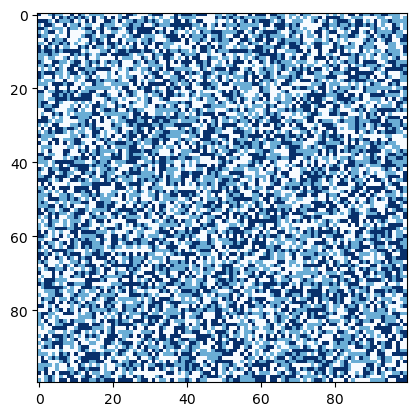

PyObject <matplotlib.image.AxesImage object at 0x0000000002330400>

In [53]:
imshow(initgame.board, cmap = "Blues")

In [54]:
outgame = simulate(initgame)

Everyone is happy!


(nrow = 100, ncol = 100, kindlist = [1 2], board = [0 0 … 0 1; 0 0 … 0 1; … ; 0 2 … 0 2; 2 0 … 2 2], kindshare_thresh = 0.3)

In [72]:
heatmap(outgame.board, cmap = "Blues")

In [71]:
display(gcf())

Figure(PyObject <Figure size 640x480 with 0 Axes>)

PyObject <matplotlib.image.AxesImage object at 0x0000000002382D60>

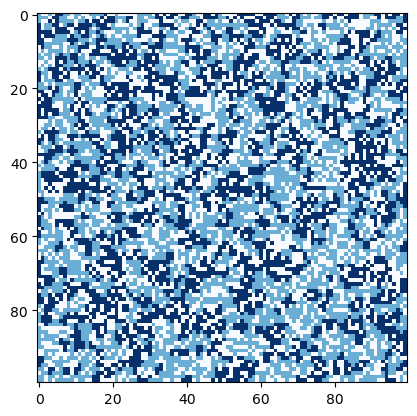

In [59]:
initgame = Game(nrow = 100, ncol = 100)
imshow(initgame.board, cmap = "Blues") |> IJulia.display
sleep(0.2)
outgame = simulate(initgame)
IJulia.clear_output(true) 
imshow(outgame.board, cmap = "Blues") |> IJulia.display

In [60]:
?imshow

search: imshow



Display data as an image, i.e., on a 2D regular raster.

The input may either be actual RGB(A) data, or 2D scalar data, which
will be rendered as a pseudocolor image. For displaying a grayscale
image set up the color mapping using the parameters
``cmap='gray', vmin=0, vmax=255``.

The number of pixels used to render an image is set by the axes size
and the *dpi* of the figure. This can lead to aliasing artifacts when
the image is resampled because the displayed image size will usually
not match the size of *X* (see
:doc:`/gallery/images_contours_and_fields/image_antialiasing`).
The resampling can be controlled via the *interpolation* parameter
and/or :rc:`image.interpolation`.

Parameters
----------
X : array-like or PIL image
    The image data. Supported array shapes are:

    - (M, N): an image with scalar data. The values are mapped to
      colors using normalization and a colormap. See parameters *norm*,
      *cmap*, *vmin*, *vmax*.
    - (M, N, 3): an image with RGB values (0-1